<a href="https://colab.research.google.com/github/Saigirish-Suryadevara/Saigirish_INFO5731_Fall2024/blob/main/Finalrpoject_BERT_Model_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets
!pip install transformers datasets torch scikit-learn pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

# Load the dataset
file_path = '/content/Bert_Eval_cleaned_reddit_comments_online.csv'  # Adjust to your file location
data = pd.read_csv(file_path)

# Prepare data for training
texts = data['comment_body']
labels = data['Final_label']

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [4]:
# Load pre-trained BERT tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

# Create Hugging Face datasets for training and validation
train_data = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_data = Dataset.from_dict({'text': val_texts, 'label': val_labels})
train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/2972 [00:00<?, ? examples/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

In [5]:
# Define BERT model for sequence classification
num_labels = len(data['Final_label'].unique())  # Number of unique labels
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True
)



# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=None
)


trainer.train()


model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-a03c7ee2bb69>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wand

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.708800,0.705540
2,0.618300,0.724847
3,0.379400,0.905949
4,0.224500,1.238965


('./fine_tuned_bert/tokenizer_config.json',
 './fine_tuned_bert/special_tokens_map.json',
 './fine_tuned_bert/vocab.txt',
 './fine_tuned_bert/added_tokens.json')

In [8]:
def predict_in_batches(texts, batch_size=32):
    # Detect if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the model to the detected device
    model.to(device)

    predictions = []
    model.eval()

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            # Tokenize the batch of texts
            encodings = tokenizer(
                list(batch_texts),
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors="pt"
            )

            # Move inputs to the same device as the model
            encodings = {key: val.to(device) for key, val in encodings.items()}

            # Get model outputs
            outputs = model(**encodings)
            logits = outputs.logits

            # Get the predicted labels for the batch
            batch_predictions = torch.argmax(logits, dim=1)

            # Append predictions to the list
            predictions.extend(batch_predictions.cpu().numpy())

    return predictions




data['Predicted_label'] = predict_in_batches(data['comment_body'])

data.to_excel('Bert_predictions.xlsx', index=False)

print("File saved to the current directory. You can download it using the file explorer on the left.")


File saved to the current directory. You can download it using the file explorer on the left.


In [9]:
!pip install matplotlib seaborn scikit-learn


  post_id                                         post_title  post_score  \
0  lfdfer  Got my verified certificate from edX for CS50'...         167   
1  lfdfer  Got my verified certificate from edX for CS50'...         167   
2  lfdfer  Got my verified certificate from edX for CS50'...         167   
3  lfdfer  Got my verified certificate from edX for CS50'...         167   
4  lfdfer  Got my verified certificate from edX for CS50'...         167   

                              post_url Keyword_search comment_id  parent_id  \
0  https://i.redd.it/8tztigeyo9g61.jpg         python    gml477z  t3_lfdfer   
1  https://i.redd.it/8tztigeyo9g61.jpg         python    gml57dm  t3_lfdfer   
2  https://i.redd.it/8tztigeyo9g61.jpg         python    gmnlv6l  t3_lfdfer   
3  https://i.redd.it/8tztigeyo9g61.jpg         python    gmrm0gn  t3_lfdfer   
4  https://i.redd.it/8tztigeyo9g61.jpg         python    gmldlvt  t3_lfdfer   

   comment_depth                                       comment_body 

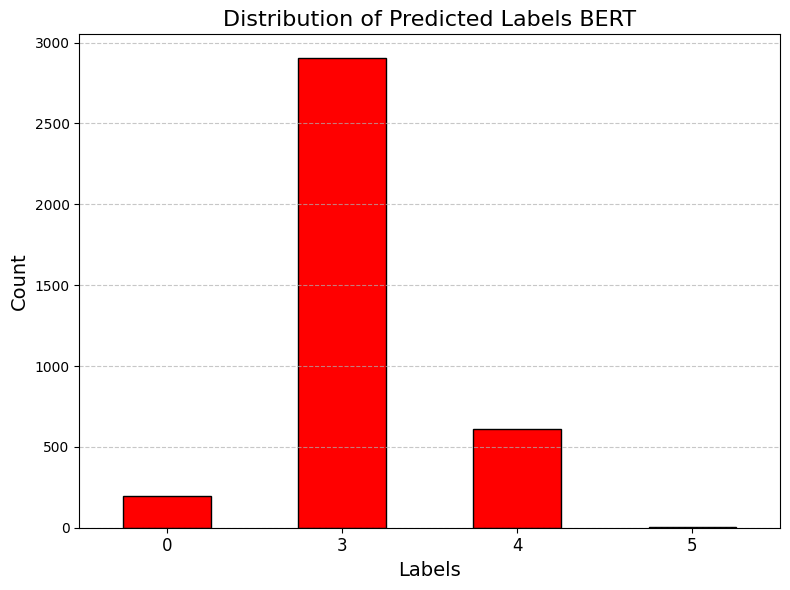

In [11]:
import matplotlib.pyplot as plt

file_path = '/content/Bert_predictions.xlsx'
df = pd.read_excel(file_path)


print(df.head())

plt.figure(figsize=(8, 6))
df['Predicted_label'].value_counts().sort_index().plot(kind='bar', color='red', edgecolor='black')


plt.title('Distribution of Predicted Labels BERT', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.7534983853606028, 'Precision': 0.735811228721584, 'Recall': 0.7534983853606028, 'F1 Score': 0.7304023287205273}


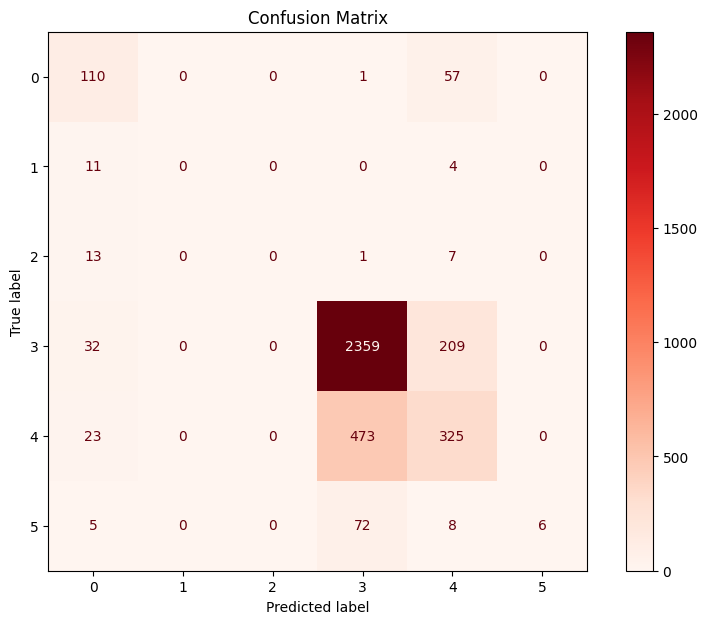

<ipython-input-17-bb1a86129e32>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Final_label', data=data, palette=final_label_palette, alpha=0.5, label='Final Labels')
<ipython-input-17-bb1a86129e32>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Predicted_label', data=data, palette=predicted_label_palette, alpha=0.5, label='Predicted Labels')


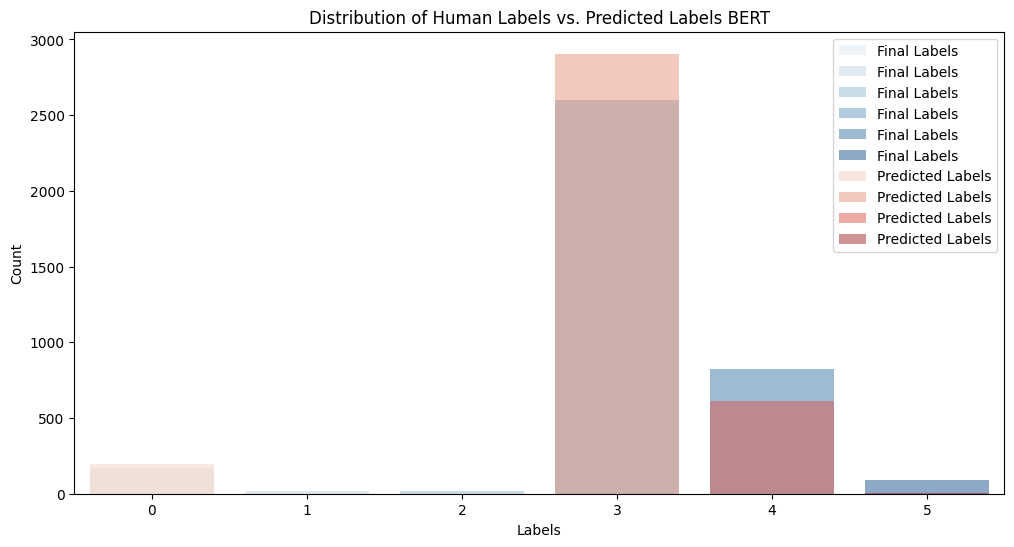

In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


file_path = '/content/Bert_predictions.xlsx'
data = pd.read_excel(file_path)


final_labels = data['Final_label']
predicted_labels = data['Predicted_label']


accuracy = accuracy_score(final_labels, predicted_labels)
precision = precision_score(final_labels, predicted_labels, average='weighted')
recall = recall_score(final_labels, predicted_labels, average='weighted')
f1 = f1_score(final_labels, predicted_labels, average='weighted')


metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}
print(metrics)

cm = confusion_matrix(final_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(data['Final_label'].unique()))


plt.figure(figsize=(10, 7))
disp.plot(cmap='Reds', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()


plt.figure(figsize=(12, 6))
final_label_palette = 'Blues'
predicted_label_palette = 'Reds'
sns.countplot(x='Final_label', data=data, palette=final_label_palette, alpha=0.5, label='Final Labels')
sns.countplot(x='Predicted_label', data=data, palette=predicted_label_palette, alpha=0.5, label='Predicted Labels')
plt.title("Distribution of Human Labels vs. Predicted Labels BERT")
plt.legend(loc='upper right')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()
